# Анализ A/B-теста

### Описание проекта

Аналитика интернет-магазина. Подготовлен список гипотез для увеличения выручки, также предоставлены данные А/В теста.

Задание: Приоритизировать гипотезы и проанализируйте результаты А/В теста.

В данном исследовании нами будет проведена приоритезация гипотез методами ICE и RICE, проанализированы результаты А/В теста: проведено сравнение конверсии и среднего чека заказа между группами.

### Оглавление

[1. Подготовка к анализу данных, создание и проверка датафреймов](#section1)  
[2. Приоритизация гипотез](#section2)  
[3. Анализ A/B-теста](#section3)  
[3.1 График кумулятивной выручки](#section3.1)  
[3.2 График кумулятивного среднего чека](#section3.2)  
[3.3 График относительного изменения кумулятивного среднего чека группы B к группе A](#section3.3)  
[3.4 График кумулятивной конверсии](#section3.4)  
[3.5 График относительного изменения кумулятивной конверсии группы B к группе A](#section3.5)  
[3.6 График количества заказов по пользователям](#section3.6)  
[3.7 Расчет персентилей количества заказов](#section3.7)  
[3.8 Точечный график стоимостей заказов](#section3.8)  
[3.9 Расчет перцентилей стоимости заказов](#section3.9)  
[3.10 Статистическая значимость различий в конверсии между группами по «сырым» данным](#section3.10)  
[3.11 Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным](#section3.11)  
[3.12 Статистическая значимость различий в конверсии между группами по «очищенным» данным](#section3.12)  
[3.13 Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным](#section3.13)  
[3.14 Решение по результатам теста](#section3.14)  
[4. Общий вывод](#section4)  


<a id='section1'> <a/>

## 1. Подготовка к анализу данных, создание и проверка датафреймов

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# создаем датафрейм df_games
path = '/content/drive/My Drive/yandex.practicum projects/datasets/7. Sprint 6/'

hipotesis = pd.read_csv(path + 'hypothesis.csv')
hipotesis.columns = ['hipotesis','reach', 'impact', 'confidence', 'efforts']
hipotesis

,hipotesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


Датафрейм с предложенными гипотезами.  

hypothesis — краткое описание гипотезы  
reach — охват пользователей по 10-балльной шкале  
impact — влияние на пользователей по 10-балльной шкале  
confidence — уверенность в гипотезе по 10-балльной шкале  
efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале  

In [4]:
orders = pd.read_csv(path + 'orders.csv')
display(orders.head())
display(orders.info())

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

In [5]:
# Изменение типа данных колонки 'date' на datetime
orders['date'] = pd.to_datetime(orders['date'])

# Проверка на дубликаты
orders.duplicated().sum()

0

Датафрейм с данными о заказах. Дубликаты в данных отсутствуют

transactionId — идентификатор заказа  
visitorId — идентификатор пользователя, совершившего заказ  
date — дата, когда был совершён заказ  
revenue — выручка заказа  
group — группа A/B-теста, в которую попал заказ  

In [6]:
visitors = pd.read_csv(path + 'visitors.csv')
display(visitors.head())
display(visitors.info())

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

In [7]:
# Изменение типа данных колонки 'date' на datetime
visitors['date'] = pd.to_datetime(visitors['date'])

# Проверка на дубликаты
visitors.duplicated().sum()

0

Датафрейм с данными о посетителях. Дубликаты в данных отсутствуют

date — дата  
group — группа A/B-теста  
visitors — количество пользователей в указанную дату в указанной группе A/B-теста  

### Вывод

На данном этапе мы загрузили датафреймы с выдвинутыми гипотезами, данные о заказах и количестве посетителей, ознакомились с ними, проверили типы данных на корректность и дубликаты.

<a id='section2'> <a/>

# 2. Приоритизация гипотез

In [8]:
# Приоритезация гипотез по методу ICE 
hipotesis['ice_score'] = (hipotesis['impact'] * hipotesis['confidence']) / hipotesis['efforts']

# Приоритезация гипотез по методу RICE 
hipotesis['rice_score'] = (hipotesis['impact'] * hipotesis['confidence'] * hipotesis['reach']) / hipotesis['efforts']

In [9]:
# Приоритизированные по методу ICE гипотезы
hipotesis.sort_values('ice_score', ascending=False)

,hipotesis,reach,impact,confidence,efforts,ice_score,rice_score
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5,16.200000,16.2
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6,13.333333,40.0
7,Добавить форму подписки на все основные страни...,10,7,8,5,11.200000,112.0
6,Показать на главной странице баннеры с актуаль...,5,3,8,3,8.000000,40.0
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3,7.000000,56.0
1,"Запустить собственную службу доставки, что сок...",2,5,4,10,2.000000,4.0
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3,1.333333,4.0
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8,1.125000,9.0
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1,1.000000,3.0


In [10]:
# Приоритизированные по методу RICE гипотезы
hipotesis.sort_values('rice_score', ascending=False)

,hipotesis,reach,impact,confidence,efforts,ice_score,rice_score
7,Добавить форму подписки на все основные страни...,10,7,8,5,11.200000,112.0
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3,7.000000,56.0
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6,13.333333,40.0
6,Показать на главной странице баннеры с актуаль...,5,3,8,3,8.000000,40.0
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5,16.200000,16.2
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8,1.125000,9.0
1,"Запустить собственную службу доставки, что сок...",2,5,4,10,2.000000,4.0
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3,1.333333,4.0
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1,1.000000,3.0


### Вывод

При применении методов приоритезации ICE и RICE мы получили различающиеся данные. Это произошло из-за того, что при приоритезации по методу ICE в расчет не берется показатель охвата пользователей, который оказывает существенное влияние при расчете RICE.

- Так, например, гипотеза 8, являющаяся лидером по методу ICE, оказалась на 5 месте в списке приоритетов по методу RICE из-за минимально возможного охвата пользователя. А лидером по методу RICE является гипотеза 7, имеющая максимальный показатель охвата и относительно высокие показатели влияния и уверенности в гипотезе. При этом у данных гипотез одинаковая трудоемкость.

Наиболее перспертивной по методу RICE гипотезой является "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок".

<a id='section3'> <a/>

# 3. Анализ A/B-теста

In [11]:
# Массив уникальных пар значений дат и групп
datesGroups = orders[['date','group']].drop_duplicates()

# Агрегированные по дням данные о заказах
ordersAggregated = datesGroups.\
    apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].\
    agg({'date' : 'max',
        'group' : 'max',
        'transactionId' : pd.Series.nunique,
        'visitorId' : pd.Series.nunique,
        'revenue' : 'sum'}), axis=1).\
    sort_values(by=['date','group'])

# Агрегированные по дням данные о посещениях
visitorsAggregated = datesGroups.apply(
lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({
'date' : 'max',
'group' : 'max',
'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

<a id='section3.1'> <a/>

**3.1 График кумулятивной выручки**

In [12]:
# Объединение ordersAggregated и visitorsAggregated
cumulativeData = ordersAggregated.merge(visitorsAggregated, on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

# датафрейм группы А с кумулятивным количеством заказов и кумулятивной выручкой по дням
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм группы В с кумулятивным количеством заказов и кумулятивной выручкой по дням
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

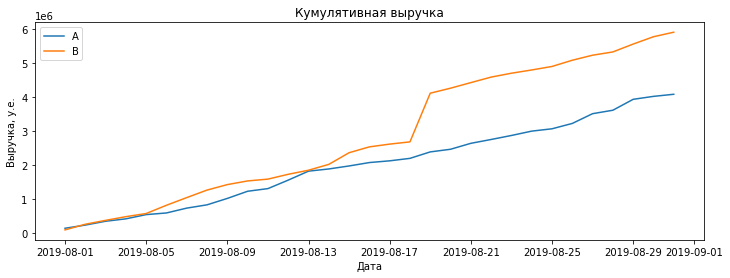

In [13]:
# График кумулятивной выручки
plt.figure(figsize=(12,4))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.title('Кумулятивная выручка')
plt.xlabel('Дата')
plt.ylabel('Выручка, у.е.')
plt.legend()
plt.show()

### Вывод

По графику кумулятивной выручки видно, что группа B опережает группу A. При этом на В сильное влияение оказал выброс, существенно увеличивший кумулятивную выручку группы В.  
Несмотря на это, если рассматривать данные без учета конкретно этого выброса, видо, что группа В начала лидировать до него и не сдавала позиции после.

<a id='section3.2'> <a/>

**3.2 График кумулятивного среднего чека**

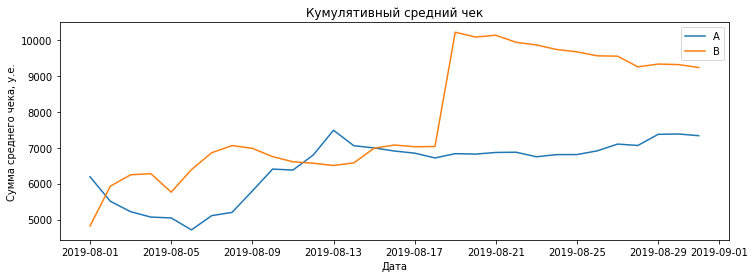

In [14]:
plt.figure(figsize=(12,4))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'] / cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'] / cumulativeRevenueB['orders'], label='B')
plt.title('Кумулятивный средний чек')
plt.xlabel('Дата')
plt.ylabel('Сумма среднего чека, у.е.')
plt.legend()
plt.show()

### Вывод

По графику кумулятивного среднего чека (по неочищенным от выбросов данным) видно, что лидирующей является группа В, при этом это произошло из-за одного большого выброса. При этом, в целом, графики кумулятивного среднего чека групп А/В направлены в одну точку.

<a id='section3.3'> <a/>

**3.3 График относительного изменения кумулятивного среднего чека группы B к группе A**

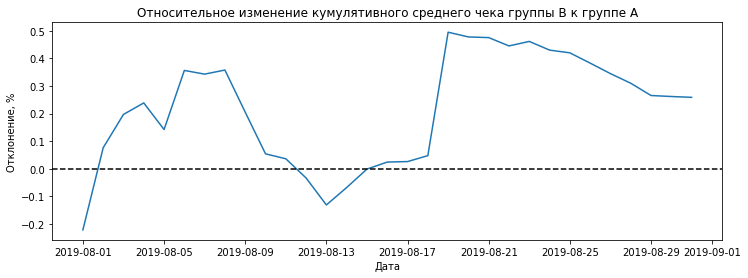

In [15]:
# Объединение датафреймов cumulativeRevenueA и cumulativeRevenueB с присвоением суффиксов столбцам 'revenue' и 'orders'
mergedCumulativeRevenue = cumulativeRevenueA.\
    merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
 
# Отношение средних чеков групп А и В
plt.figure(figsize=(12,4))
plt.plot(mergedCumulativeRevenue['date'],
        (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/\
        (mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Отклонение, %')
plt.show()

### Вывод

Многочисленные скачки на графике относительного изменения кумулятивного среднего чека группы B к группе A указывают на наличие выбросов в обоих группах. При этом большой выброс в начале второй половины проведения теста поднял в лидеры группу В, после чего началось постепенное снижение.

<a id='section3.4'> <a/>

**3.4 График кумулятивной конверсии**

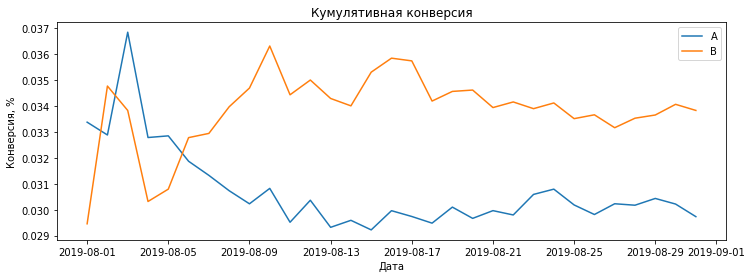

In [16]:
# Расчет кумулятивной конверсии
cumulativeData['conversion'] = cumulativeData['orders'] / cumulativeData['visitors']

# Разделение по группам
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# График кумулятивной конверсии
plt.figure(figsize=(12,4))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
#plt.axis(["2019-08-01", "2019-08-31", 0.025, 0.04])
plt.title('Кумулятивная конверсия')
plt.xlabel('Дата')
plt.ylabel('Конверсия, %')
plt.show()

### Вывод

График кумулятивной конверсии показывает уверенное лидерство группы B на протяжении практически всего теста, следовательно посетители из группы В совершают больше покупок, чем посетители из группы А.

<a id='section3.5'> <a/>

**3.5 График относительного изменения кумулятивной конверсии группы B к группе A**

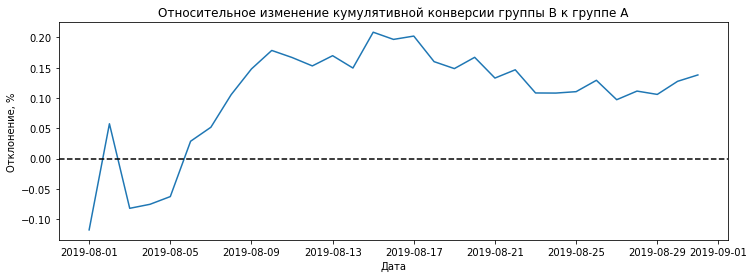

In [17]:
# Объединение датафреймов cumulativeDataA и cumulativeDataB с присвоением суффиксов столбцу 'conversion'
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].\
    merge(cumulativeDataB[['date','conversion']], on='date', how='left', suffixes=['A', 'B'])

# График относительного изменения кумулятивной конверсии группы B к группе A
plt.figure(figsize=(12,4))
plt.plot(mergedCumulativeConversions['date'],
         mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1)
plt.axhline(y=0, color='black', linestyle='--')
#plt.axis(["2019-08-01", "2019-08-31", -0.25, 0.25])
plt.title('Относительное изменение кумулятивной конверсии группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Отклонение, %')
plt.show()

### Вывод

Как и на прошлом графике, здесь видно уверенное превосходство группы B перед группой А. Посетители из группы В совершают больше покупок, чем посетители из группы А.

<a id='section3.6'> <a/>

**3.6 График количества заказов по пользователям**

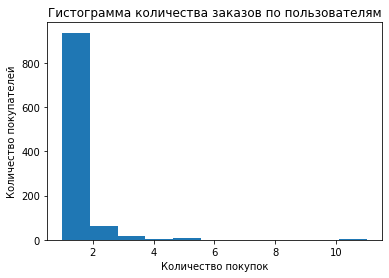

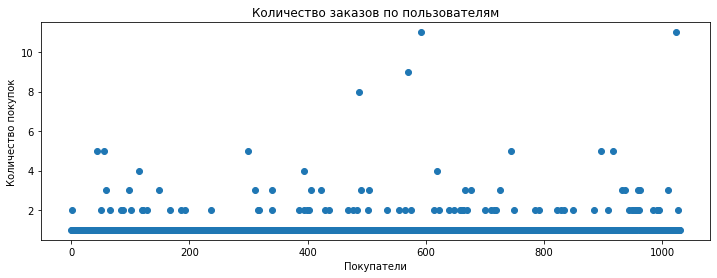

In [18]:
# Датафрейм с количеством покупок каждого покупателя
ordersByUsers = orders.\
    drop(['date','revenue','group'], axis=1).\
    groupby('visitorId', as_index=False).\
    agg({'transactionId' : pd.Series.nunique})
ordersByUsers.columns = ['userId','orders']

# Гистограмма
plt.figure(figsize=(6,4))
plt.hist(ordersByUsers['orders'], bins=11)
plt.title('Гистограмма количества заказов по пользователям')
plt.xlabel('Количество покупок')
plt.ylabel('Количество покупателей')
plt.show()

# Точечный график количества заказов по пользователям
x_values = pd.Series(range(0,len(ordersByUsers)))

plt.figure(figsize=(12,4))
plt.scatter(x_values, ordersByUsers['orders'])
plt.title('Количество заказов по пользователям')
plt.xlabel('Покупатели')
plt.ylabel('Количество покупок')
plt.show()

In [19]:
# Количество покупателей, совершающих различное количество покупок
ordersByUsers.groupby('orders').count().rename(columns={'userId':'users'})

,users
orders,
1,937
2,64
3,17
4,3
5,6
8,1
9,1
11,2


### Вывод

Абсолютное большинство покупателей совершают один заказ. Количество покупателей, совершающих два и более заказа менее 10 % от общего количества покупателей.

<a id='section3.7'> <a/>

**3.7 Расчет персентилей количества заказов**

In [20]:
# Расчет 95 и 99 персентилей количества заказов на покупателя
print('95 персентиль количества заказов на покупателя равен {:.1f}'.\
      format(float(np.percentile(ordersByUsers['orders'], [95]))))

print('99 персентиль количества заказов на покупателя равен {:.1f}'.\
      format(float(np.percentile(ordersByUsers['orders'], [99]))))

95 персентиль количества заказов на покупателя равен 2.0
99 персентиль количества заказов на покупателя равен 4.0


### Вывод

Из проведенного расчета видно, что 95 персентилем количества заказов на покупателя является 2 заказа, 99 персентилем - 4 заказа на одного покупателя.

Для анализа данных в этом исследовании выберем границу аномальных заказов на покупателя равную 95 персентилям, т.е. превышающем 2 заказа.

<a id='section3.8'> <a/>

**3.8 Точечный график стоимостей заказов**

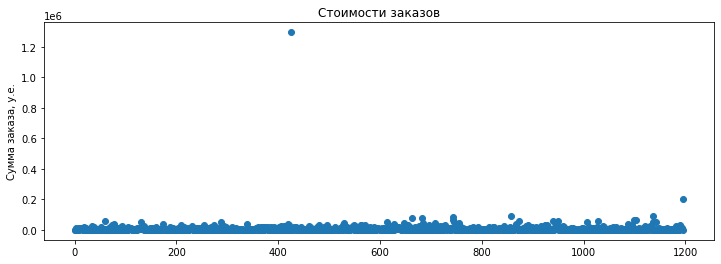

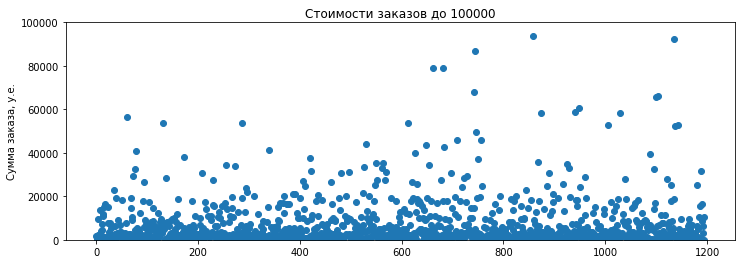

In [21]:
x_values = pd.Series(range(0,len(orders['revenue'])))

# Точечный график стоимостей заказов
plt.figure(figsize=(12,4))
plt.scatter(x_values, orders['revenue'])
plt.title('Стоимости заказов')
plt.ylabel('Сумма заказа, у.е.')
plt.show()

# Точечный график стоимостей заказов до 100000
plt.figure(figsize=(12,4))
plt.scatter(x_values, orders['revenue'])
plt.ylim(0,100000)
plt.title('Стоимости заказов до 100000')
plt.ylabel('Сумма заказа, у.е.')
plt.show()

### Вывод

Большинство стоимостей заказов расположено до 20000. При этом виден заказ на сумму больше миллиона, который значительно влиял на данные группы В.

<a id='section3.9'> <a/>

**3.9 Расчет перцентилей стоимости заказов**

In [22]:
# Расчет 95 и 99 персентилей стоимости заказов

print('95 персентиль стоимости заказов равен {:.1f} у.е.'.format(float(np.percentile(orders['revenue'], [95]))))
print('99 персентиль стоимости заказов равен {:.1f} у.е.'.format(float(np.percentile(orders['revenue'], [99]))))

95 персентиль стоимости заказов равен 28000.0 у.е.
99 персентиль стоимости заказов равен 58233.2 у.е.


### Вывод

Из проведенного расчета видно, что 95 персентилем стоимости заказов является 28000 у.е., 99 персентилем - 58233.2 у.е.

Для анализа данных в этом исследовании выберем границу аномальной стоимости заказов равную 95 персентилям, т.е. превышающем 28000 у.е.

<a id='section3.10'> <a/>

**3.10 Статистическая значимость различий в конверсии между группами по «сырым» данным**

In [23]:
# Количество посетителей по группам А/В
visitorsADaily = visitors[visitors['group']=='A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsBDaily = visitors[visitors['group']=='B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

# Накопительное количество посетителей по группам А/В
visitorsACummulative = visitorsADaily.\
    apply(lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].\
    agg({'date' : 'max', 'visitorsPerDateA' : 'sum'}), axis=1)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBCummulative = visitorsBDaily.\
    apply(lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].\
    agg({'date' : 'max', 'visitorsPerDateB' : 'sum'}), axis=1)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

# Количество покупок и выручка по группам А/В
ordersADaily = orders[orders['group']=='A'][['date', 'transactionId', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersBDaily = orders[orders['group']=='B'][['date', 'transactionId', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

# Накопительное количество покупок и накопительная выручка группам А/В
ordersACummulative = ordersADaily.\
    apply(lambda x:ordersADaily[ordersADaily['date'] <= x['date']].\
    agg({'date' : 'max',
         'ordersPerDateA' : 'sum',
         'revenuePerDateA' : 'sum'}), axis=1).\
    sort_values(by=['date'])
ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']

ordersBCummulative = ordersBDaily.\
    apply(lambda x:ordersBDaily[ordersBDaily['date'] <= x['date']].\
    agg({'date' : 'max',
         'ordersPerDateB' : 'sum',
         'revenuePerDateB' : 'sum'}), axis=1).\
    sort_values(by=['date'])
ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']

# Объединение созданных датафреймов в один
raw_data = ordersADaily.merge(ordersBDaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')\
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')\
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')

In [24]:
# Переменные ordersByUsersA и ordersByUsersB
# Для каждого покупателя указано число совершённых заказов
ordersByUsersA = orders[orders['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = orders[orders['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersB.columns = ['visitorId', 'orders']

# Переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов
sampleA = pd.concat([ordersByUsersA['orders'],\
          pd.Series(0, index=np.arange(raw_data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),\
                    name='orders')], axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],\
          pd.Series(0, index=np.arange(raw_data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),\
                    name='orders')],axis=0)

Нулевая гипотеза - Статистически значимых различий в конверсии между группами нет.  
Альтернативная гипотеза - Статистически значимые различия в конверсии между группами есть.  

In [25]:
# Значение alpha стандартное - 5%
alpha = 0.05   

# Применение U-критерия Манна-Уитни
pvalue = stats.mannwhitneyu(sampleA, sampleB)[1]

print('p-значение: {:.3f}'.format(pvalue))

if (pvalue < alpha):
    print('Отвергаем нулевую гипотезу, статистически значимые различия в конверсии между группами есть.')
else:
    print('Не получилось отвергнуть нулевую гипотезу, статистически значимых различий в конверсии между группами нет.')

# Растчет относительного прироста конверсии группы B
print('Относительный прирост конверсии группы B к конверсии группы А составляет {0:.2%}'.\
      format(sampleB.mean()/sampleA.mean()-1))

p-значение: 0.008
Отвергаем нулевую гипотезу, статистически значимые различия в конверсии между группами есть.
Относительный прирост конверсии группы B к конверсии группы А составляет 13.81%


### Вывод

По результатам применения U-критерия Манна-Уитни отвергаем нулевую гипотезу об отсутствии статистически значимых различий в конверсии между группами.  
По необработанным данным группа В лучше. Конверсия группы В на 13.81% лучше, чем конверсия группы А.


<a id='section3.11'> <a/>

**3.11 Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным**

Нулевая гипотеза - Статистически значимых различий в среднем чеке заказа между группами нет.  
Альтернативная гипотеза - Статистически значимые различия в среднем чеке заказа между группами есть.  

In [26]:
# Значение alpha стандартное - 5%
alpha = 0.05   

# Применение U-критерия Манна-Уитни
pvalue = stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]

print('p-значение: {:.3f}'.format(pvalue))

if (pvalue < alpha):
    print('Отвергаем нулевую гипотезу, статистически значимые различия в среднем чеке заказа между группами есть.')
else:
    print('Не получилось отвергнуть нулевую гипотезу, статистически значимых различий в среднем чеке заказа между группами нет.')

# Растчет относительного прироста конверсии группы B
print('Относительный прирост среднего чека заказа группы B к среднему чеку заказа группы А составляет {0:.2%}'.\
      format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

p-значение: 0.365
Не получилось отвергнуть нулевую гипотезу, статистически значимых различий в среднем чеке заказа между группами нет.
Относительный прирост среднего чека заказа группы B к среднему чеку заказа группы А составляет 25.87%


### Вывод

По результатам применения U-критерия Манна-Уитни нулевую гипотезу не отвергаем.  
Статистически значимых различий в среднем чеке заказа между группами нет, но при этом по необработанным данным группа В лучше. Средний чек заказа группы B на 25.87% больше среднего чека заказа группы А.  
Данное расхождение говорит о необходимости проверки на очищеных от аномальных значений данных.

<a id='section3.12'> <a/>

**3.12 Статистическая значимость различий в конверсии между группами по «очищенным» данным**

In [27]:
# Переменные для отсечения выбросов
percentile_95_orders = float(np.percentile(ordersByUsers['orders'], [95]))
percentile_95_revenue= float(np.percentile(orders['revenue'], [95]))

# Пользователи с количеством покупок большим, чем у 95% покупателей
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > percentile_95_orders]['visitorId'],\
                                 ordersByUsersB[ordersByUsersB['orders'] > percentile_95_orders]['visitorId']], axis = 0)

# Пользователи с суммой покупки большей, чем у 95% покупателей
usersWithExpensiveOrders = orders[orders['revenue'] > percentile_95_revenue]['visitorId']

# Список с visitorId аномальных пользователей
anomalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()

In [28]:
# Очищенные от аномальных значений выборки количества заказов по пользователям
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['visitorId'].isin(anomalUsers))]['orders'],\
                             pd.Series(0, index=np.arange(raw_data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),\
                            name='orders')],axis=0)

sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['visitorId'].isin(anomalUsers))]['orders'],\
                             pd.Series(0, index=np.arange(raw_data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),\
                            name='orders')],axis=0)

Нулевая гипотеза - Статистически значимых различий в конверсии между группами по очищенным данным нет.  
Альтернативная гипотеза - Статистически значимые различия в конверсии между группами по очищенным данным есть.  

In [29]:
# Значение alpha стандартное - 5%
alpha = 0.05   

# Применение U-критерия Манна-Уитни
pvalue = stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]

print('p-значение: {:.3f}'.format(pvalue))

if (pvalue < alpha):
    print('Отвергаем нулевую гипотезу, статистически значимые различия в конверсии между группами по очищенным данным есть.')
else:
    print('Не получилось отвергнуть нулевую гипотезу, статистически значимых различий в конверсии между группами по очищенным данным нет.')

# Растчет относительного прироста конверсии группы B
print('Относительный прирост конверсии группы B к конверсии группы А составляет {0:.2%}'.\
      format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

p-значение: 0.007
Отвергаем нулевую гипотезу, статистически значимые различия в конверсии между группами по очищенным данным есть.
Относительный прирост конверсии группы B к конверсии группы А составляет 17.27%


### Вывод

По результатам применения U-критерия Манна-Уитни отвергаем нулевую гипотезу об отсутствии статистически значимых различий в конверсии между группами по очищенным данным.

По обработанным данным группа В лучше. Конверсия группы В на 17.27% выше, чем конверсия группы А. При этом по очищенным данным результаты группы В превосходят результаты группы В по сырым данным.


<a id='section3.13'> <a/>

**3.13 Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным**

Нулевая гипотеза - Статистически значимых различий в среднем чеке заказа между группами по очищенным данным нет.  
Альтернативная гипотеза - Статистически значимые различия в среднем чеке заказа между группами по очищенным данным есть.

In [30]:
# Значение alpha стандартное - 5%
alpha = 0.05   

# Применение U-критерия Манна-Уитни
pvalue = stats.mannwhitneyu(\
                orders[np.logical_and(orders['group']=='A',
                    np.logical_not(orders['visitorId'].isin(anomalUsers)))]['revenue'],
                orders[np.logical_and(orders['group']=='B',
                    np.logical_not(orders['visitorId'].isin(anomalUsers)))]['revenue'])[1]

print('p-значение: {:.3f}'.format(pvalue))

if (pvalue < alpha):
    print('Отвергаем нулевую гипотезу, статистически значимые различия в среднем чеке заказа между группами есть.')
else:
    print('Не получилось отвергнуть нулевую гипотезу, статистически значимых различий в среднем чеке заказа между группами нет.')

# Растчет относительного прироста конверсии группы B
print('Относительный прирост среднего чека заказа группы B к среднему чеку заказа группы А составляет {0:.2%}'.\
      format(orders[np.logical_and(orders['group']=='B',
                 np.logical_not(orders['visitorId'].isin(anomalUsers)))]['revenue'].mean()/
             orders[np.logical_and(orders['group']=='A',
                 np.logical_not(orders['visitorId'].isin(anomalUsers)))]['revenue'].mean() - 1))

p-значение: 0.369
Не получилось отвергнуть нулевую гипотезу, статистически значимых различий в среднем чеке заказа между группами нет.
Относительный прирост среднего чека заказа группы B к среднему чеку заказа группы А составляет -1.96%


### Вывод

По результатам применения U-критерия Манна-Уитни нулевую гипотезу не отвергаем. Статистически значимых различий в среднем чеке заказа между группами по очищенным данным нет.  
По очищенным данным средний чек заказа группы B на 1.96% меньше среднего чека заказа группы А.

<a id='section3.14'> <a/>

**3.14 Решение по результатам теста**

**Решение по результатам теста - Остановить тест, зафиксировать победу группы В.**  

Несмотря на то, что по очищенным данным средний чек заказа группы B на 2% меньше среднего чека заказа группы А (что может являться статистической погрешностью) конверсия группы B на 17% превышает конверсию группы А.

<a id='section4'> <a/>

# 4. Общий вывод

В данном исследовании была проведена приоритезация гипотез и проведен анализ А/В теста.  

Приоритезация гипотез была проведена методами приоритезации ICE и RICE. Наиболее перспертивной по методу RICE гипотезой является "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок".

По неочищенным данным в конверсии пользователей и в размере среднего чека заказа лидировала группа В. При этом в неочищенных данных наблюдались аномальные значения.  
По необработанным данным относительный прирост конверсии группы B к конверсии группы А составлял 14%, относительный прирост среднего чека заказа группы B к среднему чеку заказа группы А составлял 26%.

Для очищения данных от аномальных значений были выбраны:
- 95 персентиль количества заказов на одного покупателя (2 заказа);
- 95 персентиль стоимости заказа (28000 у.е.)

По обработанным данным конверсия группы В на 17.27% выше, чем конверсия группы А. Относительный прирост среднего чека заказа группы B к среднему чеку заказа группы А составляет -1.96%.

**Решение по результатам теста - Остановить тест, зафиксировать победу группы В.**

Несмотря на то, что по очищенным данным средний чек заказа группы B на 2% меньше среднего чека заказа группы А (что может являться статистической погрешностью), конверсия группы B на 17% превышает конверсию группы А, что является существенным приростом.